# Cardinal

A Quick Start guide for Cardinal. For more details on algorithms and options, see ```cardinal_usersguide.ipynb```

This notebook uses three data examples (stored as .pickle and .cardinal files). The first .pickle file is provided with the Cardinal distribution. Contact me if you wish to run the remaining two examples.

Stephen Arrowsmith (sarrowsmith@smu.edu)

In [1]:
%matplotlib widget
from obspy import read, Stream
import sys, dask, time
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('/Users/sarrowsmith/Box/Work/github/cardinal/')
import cardinal

## UTTR Example

The UTTR example ships with InfraPy and is provided here for comparison. It contains data from a short-aperture array (BRP) and includes the measurement of a large explosion

In [2]:
st = read('UTTR.pickle')

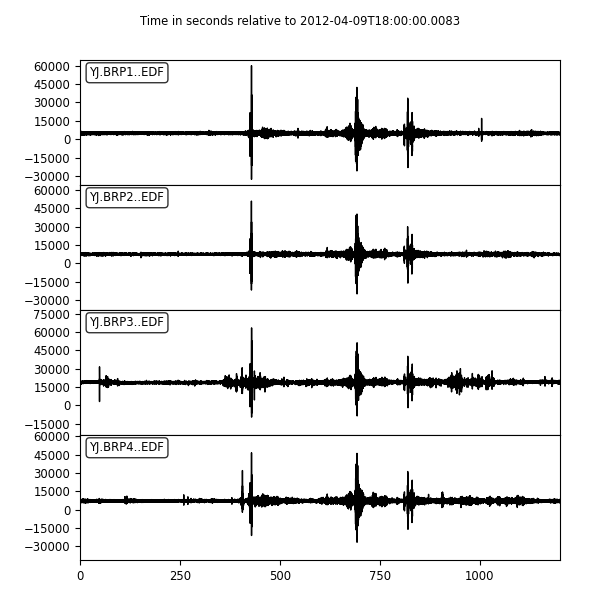

In [3]:
fig = st.plot(handle=True, method='full', type='relative', size=(600, 600))

### Extracting coordinates and f_bands from Cardinal

All array processing in Cardinal requires the specification of a reference array element. All times of estimated waveform parameters are subsequently relative to that array element.

In the example below, the reference array element is BRP4. The matrix X is required for Cardinal processing and contains the array coordinates.

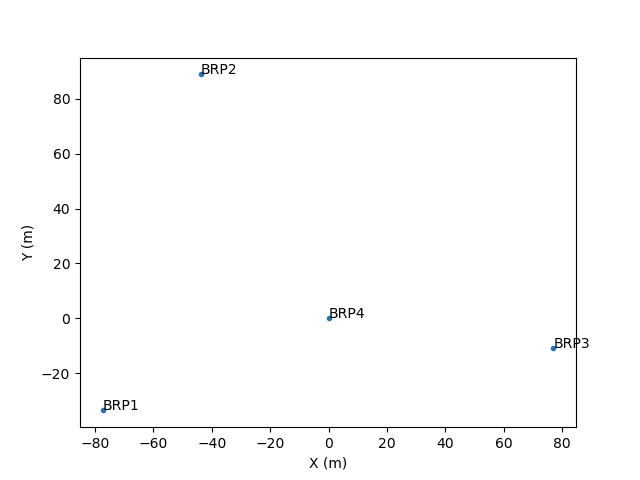

In [4]:
plt.figure()
X, stnm = cardinal.get_array_coords(st, 'BRP4')
cardinal.plot_array_coords(X, stnm, units='m')

### Obtaining PMCC filter bands

The set of PMCC filter bands and associated time windows and overlaps for array processing are described in Table 1 of Matoza et al. (2013) https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2012GL054329

The following two lines extract these parameters, and extend them up to the Nyquist frequency (note that the default PMCC filter bands only extend up to 5 Hz).

In [5]:
f_bands = cardinal.pmcc_fbands()
f_bands = cardinal.extend_pmcc_fbands(f_bands, st[0].stats.sampling_rate/2)

In [6]:
f_bands

,band,fmin,fcenter,fmax,win,step
0,1.0,0.010000,0.012600,0.015100,200.000000,20.000000
1,2.0,0.015100,0.019000,0.022900,142.160600,14.216100
2,3.0,0.022900,0.028800,0.034700,103.940400,10.394000
3,4.0,0.034700,0.043600,0.052400,78.684600,7.868500
4,5.0,0.052400,0.065900,0.079400,61.995600,6.199600
5,6.0,0.079400,0.099700,0.120100,50.967600,5.096800
6,7.0,0.120100,0.150900,0.181800,43.680300,4.368000
7,8.0,0.181800,0.228400,0.275100,38.864800,3.886500
8,9.0,0.275100,0.345700,0.416300,35.682800,3.568300
9,10.0,0.416300,0.523100,0.630000,33.580100,3.358000


### Running Array Processor over multiple frequency bands

The examples below demo two ways to run the array processor over multiple frequency bands, depending on how to multithread the code.

In both cases, the outputs are a vector of times (```T```), and matrices that contain the backazimuth (```B```), trace (or phase) velocity (```V```), and semblance (```S```). These matrices have dimension $(N_f, N_t)$ where $N_f$ is the number of frequency bands and $N_t$ is the number of time windows in the highest frequency band. The results from frequency bands with longer time windows are resampled onto the shortest time window spacing.

#### Sending different f-bands to different threads
Cardinal can process the set of frequency bands and time windows described above in multiple frequency bands by sending different bands to different threads. The number of threads to allocate to this process is defined by n_workers in the example below.

In [7]:
t0 = time.time()
T, B, V, S = cardinal.sliding_time_array_fk_multifreq(st, 'BRP4', f_bands, t_start=250, t_end=1000, n_workers=12)
print('Elapsed time = ', time.time()-t0)

Elapsed time =  14.186363935470581


#### Sending different time windows to different threads
An alternative way to run Cardinal is to do multithreading by time block. This is recommended for processing longer segments of data, and is generally faster. The way to do this is exactly as in the example above, but calling the function ```sliding_time_array_fk_multifreq_tblock```:

```python
t0 = time.time()
T, B, V, S = cardinal.sliding_time_array_fk_multifreq_tblock(st, 'BRP4', f_bands, t_start=250, t_end=1000, n_workers=12)
print('Elapsed time = ', time.time()-t0)
```

#### Plotting the results
Results can be viewed using the ```plot_sliding_window_multifreq``` function, which contains several configurable options. For example:
- ```plot_trace_vel``` is ```True``` to plot trace velocity instead of semblance
- ```log_freq``` is ```True``` to plot the frequency axes on log scales

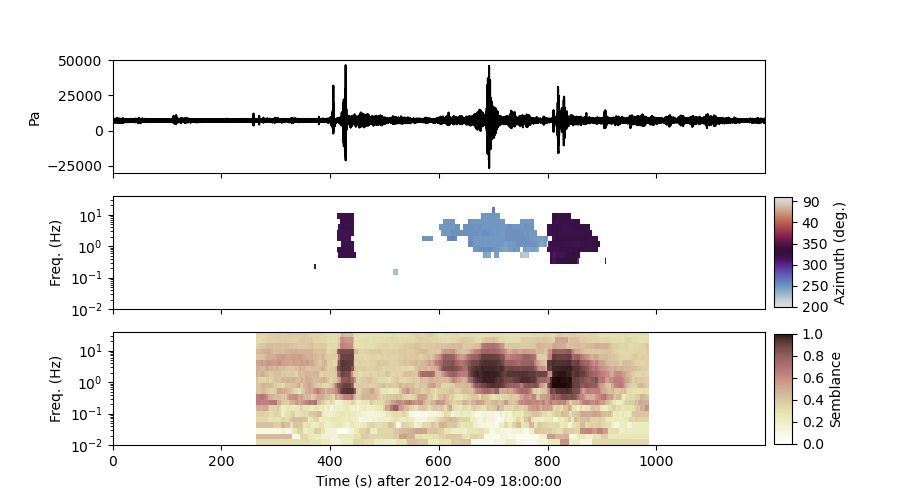

In [8]:
cardinal.plot_sliding_window_multifreq(st, 'BRP4', f_bands, T, B, V, S,
                                       semblance_threshold=0.7, clim_baz=[200, 100], clim_vtr=[0,1],
                                       plot_trace_vel=False, log_freq=True,
                                      plot_real_amplitude=True)

### Building detections

The results from array processing can be further processed to build detections (or 'families') by grouping pixels together based on time, frequency, backazimuth, and trace velocity.

There are several parameters that can be defined for ```make_families```, including the semblance threshold and other parameters related to the weighted distance used in clustering pixels. These are described more completely in ```cardinal_usersguide.ipynb```.

The outputs include ```ix``` and ```pixels_in_families```, which can be provided as input to ```plot_sliding_window_multifreq``` in order to plot only pixels that are in families (see example below). Finally, the output ```families``` contains the detections (which can be summarized in a Pandas dataframe or written to a SQLite database as shown below).

In [9]:
ref_time = st[0].stats.starttime.matplotlib_date
ix, pixels_in_families, families = cardinal.make_families(T, B, V, S, f_bands, ref_time,
                                                          dist_thres=2, min_pixels=10,
                                                          sigma_b=10,
                                                          threshold=0.7)

The example below shows how to summarize the detections in a Pandas dataframe.

In [10]:
cardinal.df_families(ref_time, families)

,start_time,end_time,min_freq,max_freq,mean_baz,std_baz,mean_vel,std_vel,max_semb,n_pixels
0,412.278502,444.728497,0.5231,9.508613,319.901945,1.695436,0.393654,0.024866,0.939250,80.0
1,601.078494,798.728498,0.5231,14.389546,248.887853,4.900566,0.341244,0.017460,0.977119,329.0
2,798.728498,893.128499,0.3457,9.508613,321.873288,4.306947,0.387639,0.110184,0.994536,214.0


Compare the results in the figure below (which shows pixels exceeding the semblance threshold that are in families) with the figure above, which shows all pixels exceeding the semblance threshold.

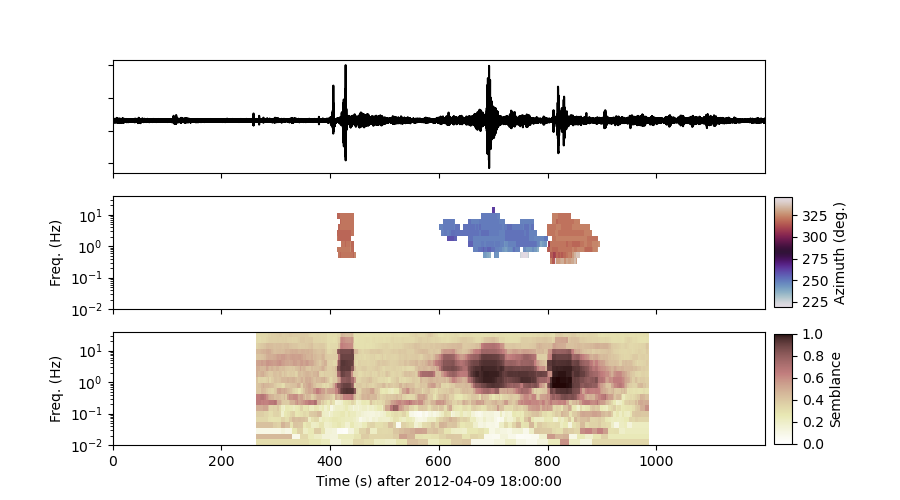

In [11]:
cardinal.plot_sliding_window_multifreq(st, 'BRP4', f_bands, T, B, V, S,
                                       semblance_threshold=0.7, clim_baz=None, clim_vtr=[0,1],
                                       plot_trace_vel=False, log_freq=True,
                                       pixels_in_families=pixels_in_families, ix=ix,)

The following code block writes the output to a SQLite3 database called ```UTTR.sql```, which can store all results.

In [12]:
cardinal.write_families_to_db('UTTR.sql', families)

### Running array processor over a single frequency band

To process only a single frequency band, as is more typical for array processing, just do the following.

In [13]:
T, B, V, S = cardinal.sliding_time_array_fk(st, 'BRP4', 250, 1000)

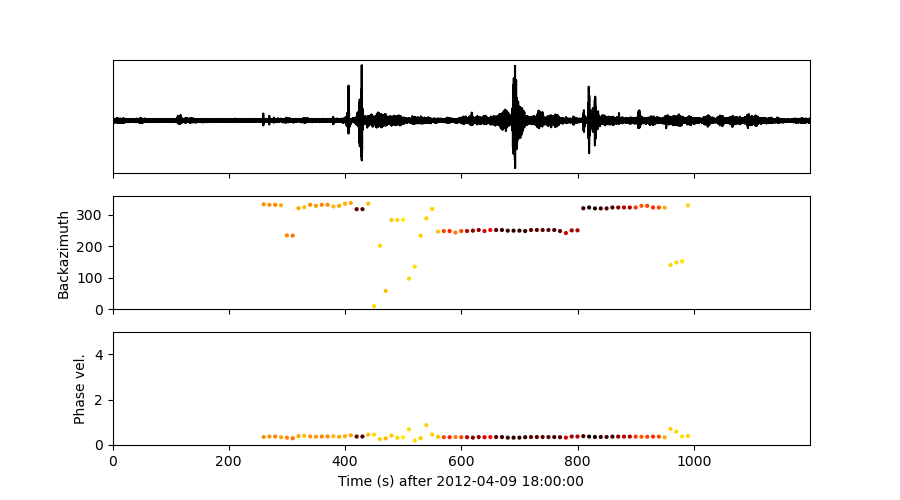

In [14]:
cardinal.plot_sliding_window(st, 'BRP4', T, B, V, C=S)

## Oklahoma example

The Oklahoma array, YW, is great for illustrating some features of Cardinal because its hard and has lots of issues. In particular, it requires a slowness correction to time-align the waveforms before applying array processing. In addition, channel 601 has a reverse polarity. Finally, the array is not really configured for the frequencies of study.

In [15]:
st_all = read('YW.pickle')

# Now we're going to throw out everything except channels 601, 602, and 603:
st = Stream()
st.append(st_all.select(station='601')[0])
st.append(st_all.select(station='602')[0])
st.append(st_all.select(station='603')[0])

# Fixing a polarity issue at Station 601:
st.select(station='601')[0].data = -1*st.select(station='601')[0].data

FileNotFoundError: [Errno 2] No such file or directory: 'YW.pickle'

In [16]:
st.taper(type='cosine', max_percentage=0.05, max_length=60)
st.filter('bandpass', freqmin=2, freqmax=15)
fig = st.plot(handle=True, method='full', type='relative', equal_scale=False, size=(600, 600))
plt.xlim([1200,1300])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(1200.0, 1300.0)

In [17]:
plt.figure()

X, stnm = cardinal.get_array_coords(st, '602')
cardinal.plot_array_coords(X, stnm, units='km')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Applying slowness correction

The next block applies a slowness correction for a backazimuth of 144.09 degrees and phase velocity of 0.35 km/s. These parameters are based on a measurement made by Chris Hayward on a single first phase, and are good enough to time-align for array processing.

In [18]:
sl_x, sl_y = cardinal.convert_to_slowness(144.09, 0.35)
st_sc = st.copy()    # st_sc is an ObsPy Stream with slowness correction applied
st_sc = cardinal.adjust_times_for_slowness(st_sc, X, sl_x, sl_y)

In [19]:
fig = st_sc.plot(handle=True, method='full', type='relative', equal_scale=False, size=(600, 600))
plt.xlim([1200,1300])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(1200.0, 1300.0)

### Processing a single frequency band

The first step is to process a single frequency band from 2-15 Hz using a 3 s window, more-or-less as we've been doing so far.

In [20]:
T, B, V, S = cardinal.sliding_time_array_fk(st_sc, '602', 1230, 1310, win_len=3, win_frac=0.1,
                                            frqlow=2, frqhigh=15, sl_corr=[sl_x, sl_y])

In [21]:
cardinal.plot_sliding_window(st_sc, '602', T, B, V, C=S, twin_plot=[1230,1310])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Processing with multiple frequency bands

The next step is to process the data with multiple frequency bands. Rather than extrapolating the default PMCC parameters to high frequencies, we use here a set of Octave bands that extends to short-time windows at high frequencies.

In [22]:
f_bands = cardinal.make_custom_fbands(f_max=st_sc[0].stats.sampling_rate/2, type='octave')

In [23]:
f_bands

,band,fmin,fcenter,fmax,win,step
0,1.0,0.01,0.015,0.02,134.320197,13.432020
1,2.0,0.02,0.030,0.04,68.640395,6.864039
2,3.0,0.04,0.060,0.08,35.800493,3.580049
3,4.0,0.08,0.120,0.16,19.380543,1.938054
4,5.0,0.16,0.240,0.32,11.170567,1.117057
5,6.0,0.32,0.480,0.64,7.065580,0.706558
6,7.0,0.64,0.960,1.28,5.013086,0.501309
7,8.0,1.28,1.920,2.56,3.986839,0.398684
8,9.0,2.56,3.840,5.12,3.473716,0.347372
9,10.0,5.12,7.680,10.24,3.217154,0.321715


In [24]:
t0 = time.time()
T, B, V, S = cardinal.sliding_time_array_fk_multifreq(st_sc, '602', f_bands, t_start=1230, t_end=1310,
                                                      n_workers=12, sl_corr=[sl_x, sl_y])
print('Elapsed time = ', time.time()-t0)

Elapsed time =  10.009031057357788


In [25]:
cardinal.plot_sliding_window_multifreq(st_sc, '602', f_bands, T, B, V, S,
                                       semblance_threshold=0.7, clim_baz=[120,160], clim_vtr=[0.1,0.5],
                                       plot_trace_vel=True, log_freq=False, twin_plot=[1230,1310],
                                       f_lim=[0,15])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## DUN Example

The final example illustrates how to process a long time period of data with Cardinal. The general workflow is to read and process data in long time blocks (e.g., 1-day). The user can optionally save a ```.cardinal``` file for each time block (which contains all the processing results prior to computing families). This is useful for going back and analyzing the results quickly.

The subsequent step is to compute families and save these to an output SQLite3 file. The results from multiple days can be appended onto the same SQLite3 file. This SQLite3 file can be queried, and summary plots can be produced from it.

This is illustrated below using data from the Dallas Urban Noise (DUN) infrasound array, which was deployed during the summer of 2020. The data were processed in chunks of 1-day, and saved as ```.cardinal``` files, as in the example below:

```python
T, B, V, S = cardinal.sliding_time_array_fk_multifreq_tblock(st, 'DUN2', f_bands, n_workers=12)
cardinal.save_sliding_window_multifreq('DUN_072520.cardinal', st, f_bands, T, B, V, S)
```

The steps below begin by reading in a ```.cardinal``` file.

In [2]:
st, f_bands, T, B, V, S = cardinal.load_sliding_window_multifreq('DUN_070520.cardinal')

Next, the ```make_families``` utility is run to build families. A reference time is provided to enable the results to be stored in either seconds (as for ```T``` above), or in Matplotlib datenum format.

In [28]:
ref_time = st[0].stats.starttime.matplotlib_date
ix, pixels_in_families, families = cardinal.make_families(T, B, V, S, f_bands, ref_time,
                                                          threshold=0.6, dist_thres=1,
                                                          min_pixels=20, sigma_t=1.5)

The families can be viewed directly as follows:

In [29]:
cardinal.df_families(ref_time, families)

,start_time,end_time,min_freq,max_freq,mean_baz,std_baz,mean_vel,std_vel,max_semb,n_pixels
133,10277.000010,10303.550007,0.5231,4.1520,253.538669,6.069255,0.388374,0.025612,0.835924,55.0
0,16270.450010,16329.450012,0.0126,0.0126,135.000000,0.000000,0.196419,0.000000,0.657468,21.0
38,23314.100007,23349.500006,0.2284,0.5231,53.927105,3.593952,0.497476,0.049454,0.755950,22.0
73,24573.750014,24615.050011,0.3457,0.5231,46.916917,4.044134,0.510296,0.030889,0.722622,22.0
39,24904.150012,25042.800014,0.2284,0.3457,32.846951,9.773271,0.593285,0.118295,0.761793,51.0
...,...,...,...,...,...,...,...,...,...,...
7,83740.200013,83796.250011,0.0436,0.0997,308.223652,6.315321,0.228743,0.035045,0.814652,40.0
71,84215.150012,84247.600007,0.2284,1.1980,147.372056,7.098783,0.258115,0.042468,0.749697,44.0
177,84262.350008,84291.850008,1.1980,2.7436,213.515060,2.250493,0.578543,0.015421,0.853106,29.0
72,84339.050014,84371.500009,0.2284,0.5231,141.763936,3.749537,0.237121,0.027790,0.720228,25.0


They can be summarized as a polar plot (which shows each family and its associated backazimuth and trace velocity, color coded by time of day, where symbol sizes represent the family size).

In [30]:
cardinal.polar_plot_families(families)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

You can also compare the output of Cardinal processing both before, and after, producing families using the ```ix``` and ```pixels_in_families``` output variables.

The first example shows the results of processing before computing families:

In [31]:
cardinal.plot_sliding_window_multifreq(st, 'DUN2', f_bands, T, B, V, S,
                                       semblance_threshold=0.6, clim_baz=None, 
                                       clim_vtr=[0,1],
                                       plot_trace_vel=True, log_freq=False,
                                       figsize=(8,5))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

The next example shows the results of processing afterwards:

In [32]:
cardinal.plot_sliding_window_multifreq(st, 'DUN2', f_bands, T, B, V, S,
                                       semblance_threshold=0.6, clim_baz=None, 
                                       clim_vtr=[0,1],
                                       pixels_in_families=pixels_in_families, ix=ix,
                                       plot_trace_vel=True, log_freq=False,
                                       figsize=(8,5))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Finally, the families can be written to, and read from, a SQLite3 database as follows:

In [33]:
cardinal.write_families_to_db('DUN.sql', families)

In [34]:
families = cardinal.read_families_from_db('DUN.sql')

For processing multiple days, the results of each successive day can simply be appended onto the same SQLite3 file.